In [196]:
import numpy as np
import random
from matplotlib import pyplot as plt
from matplotlib import animation

In [211]:
class particle_array():
    def __init__(self, n, dims):
        self.lbound = dims[0]
        self.ubound = dims[1]
        self.llimit = dims[2]
        self.ulimit = dims[3]
        particle_spacing = np.linspace(self.lbound, self.ubound, n, dtype = float)
        particle_array = np.array(np.meshgrid(particle_spacing, particle_spacing, particle_spacing)).T.reshape(-1,3)
        self.particles = [particle(coordinates, 
                                   [0, 0, 0]) for coordinates in particle_array]
        for particle_1 in self.particles:
            total = 0
            for particle_2 in self.particles:
                if id(particle_1) != id(particle_2):
                    total += particle_2.m * pairwise_calculator(particle_1, particle_2).gaus_kern()
            particle_1.initrho = total
            particle_1.rho = total
        self.calc_pressure()
        self.calc_accel()
        self.calc_veloc()
            
    def get_specific_pos(self, n):
        return self.particles[n].p
    def get_position(self):
        for particle in self.particles:
            print(particle.p)
    def get_specific_direction(self,n):
        return self.particles[n].d
    def get_direction(self):
        for particle in self.particles:
            print(particle.d)
    def get_initrho(self):
        for particle in self.particles:
            print(particle.initrho)
    def get_initpre(self):
        for particle in self.particles:
            print(particle.initpre)
    def get_rho(self):
        for particle in self.particles:
            print(particle.rho)
    def get_pre(self):
        for particle in self.particles:
            print(particle.pre)
    def get_accel(self):
        for particle in self.particles:
            print(particle.a)
    def get_veloc(self):
        for particle in self.particles:
            print(particle.d)
            
    def calc_accel(self):
        for particle_1 in self.particles:
            total = 0
            for particle_2 in self.particles:
                if id(particle_1) != id(particle_2):
                    total += (particle_2.m)*\
                    ((particle_1.pre / (particle_1.rho ** 2)) + (particle_2.pre / (particle_2.rho ** 2))) *\
                    (pairwise_calculator(particle_1, particle_2).dgaus_kern())
            particle_1.a = -total
        return particle_1.a
            
    def calc_veloc(self):
        for particle in self.particles:
            for i in range(3):
                if i == 2:
                    potential_speed = (particle.dt * particle.a) - (particle.dt * particle.g)
                    if potential_speed + particle.d[i] > particle.vmax:
                        particle.d[i] = particle.vmax
                    elif potential_speed + particle.d[i] < -particle.vmax:
                        particle.d[i] = -particle.vmax
                    else:
                        particle.d[i] += potential_speed
                else:
                    potential_speed = (particle.dt * particle.a)
                    if potential_speed + particle.d[i] > particle.vmax:
                        particle.d[i] = particle.vmax
                    elif potential_speed + particle.d[i] < -particle.vmax:
                        particle.d[i] = -particle.vmax
                    else:
                        particle.d[i] += potential_speed
                        
    def move(self):
        for particle in self.particles:
            potential_positions = particle.p.copy()
            for i in range(3):
                potential_positions[i] += particle.d[i] * particle.dt
                if potential_positions[i] < self.llimit:
                    potential_positions[i] = self.llimit
                    particle.d[i] *= -1
                elif potential_positions[i] > self.ulimit:
                    potential_positions[i] = self.ulimit
                    particle.d[i] *= -1
                particle.p = potential_positions
                
    def calc_density(self):
        for particle_1 in self.particles:
            total = 1      # I changed this to 1 cus it shld be wrt ur initial density?
            for particle_2 in self.particles:
                if id(particle_1) != id(particle_2):
                    total += particle_2.m * pairwise_calculator(particle_1, particle_2).gaus_kern()
                particle_1.rho = total
                
    def calc_pressure(self):
        for particle in self.particles:
            particle.pre = (((0.01**2) * 1)/7) * ((particle.rho / 1)**7 - 1)    # i dont rmb what i did but i played with the values here
        return particle.pre
            

In [212]:
class particle():
    def __init__(self, position, direction):
        self.p = position
        self.d = direction
        self.m = 1
        self.dt = 0.5 #s
        self.initrho = 1
        self.rho = 0
        self.pre = 0
        self.vmax = 10
        self.a = 0
        self.g = 9.81
    
    def get_magnitude(self):
        x, y, z = self.p
        return ((x**2) + (y**2) + (z**2))**(1/2)
        #return np.linalg.norm(self.p) This one works too

In [213]:
class pairwise_calculator():
    def __init__(self, particle1, particle2):
        self.p1 = particle1
        self.p2 = particle2
        
    def gaus_kern(self, h = 1, d = 3):
        mag_1 = self.p1.get_magnitude()
        mag_2 = self.p2.get_magnitude()
        delta_mag = mag_1 - mag_2
        return ((1 / h*(np.pi**(1/2)))**d) * (np.e**(-(delta_mag**2) / (h**2)))
    
    def dgaus_kern(self, h = 1, d = 3):
        mag_1 = self.p1.get_magnitude()
        mag_2 = self.p2.get_magnitude()
        delta_mag = mag_1 - mag_2
        return -((2*np.e**(-(delta_mag**2) / (h**2)))*(delta_mag)) / ((h**5)*(np.pi*(3/2)))

In [214]:
my_particles = particle_array(3, [0, 10, 0, 20])

for i in range(50):
    print("position = " + str(my_particles.get_specific_pos(0)))
    print("velocity = " + str(my_particles.get_specific_direction(0)))
    print("acc = " + str(my_particles.calc_accel()))
    print("pressure = " + str(my_particles.calc_pressure()))
    my_particles.move()
    my_particles.calc_density()
    my_particles.calc_pressure()
    my_particles.calc_accel()
    my_particles.calc_veloc()

position = [0. 0. 0.]
velocity = [10, 10, 10]
acc = 0.5083950977459167
pressure = -1.4285714050271266e-05
position = [5. 5. 5.]
velocity = [10, 10, 10]
acc = -1.0946447563995127e-07
pressure = 8.723179531092537e-12
position = [10. 10. 10.]
velocity = [10, 10, 6.272112036128608]
acc = -57.80050586644681
pressure = 72847.64598697094
position = [15.         15.         13.13605602]
velocity = [10, 10, 5.304697248077726]
acc = 568.6128392106624
pressure = 46268.21101098698
position = [20.         20.         15.78840464]
velocity = [10, 10, 1.2169440849130924]
acc = 21.20571084768185
pressure = 14518.779524000878
position = [20.         20.         16.39687668]
velocity = [-10, -10, -4.352492863835144]
acc = -2.303527612584436
pressure = 5.16039669217811
position = [15.         15.         14.22063025]
velocity = [-10, -10, -9.285540048906096]
acc = 36.01883082564955
pressure = 61.185331534921914
position = [10.         10.          9.57786023]
velocity = [-10, -10, -10]
acc = 0.2034669148

<IPython.core.display.Javascript object>


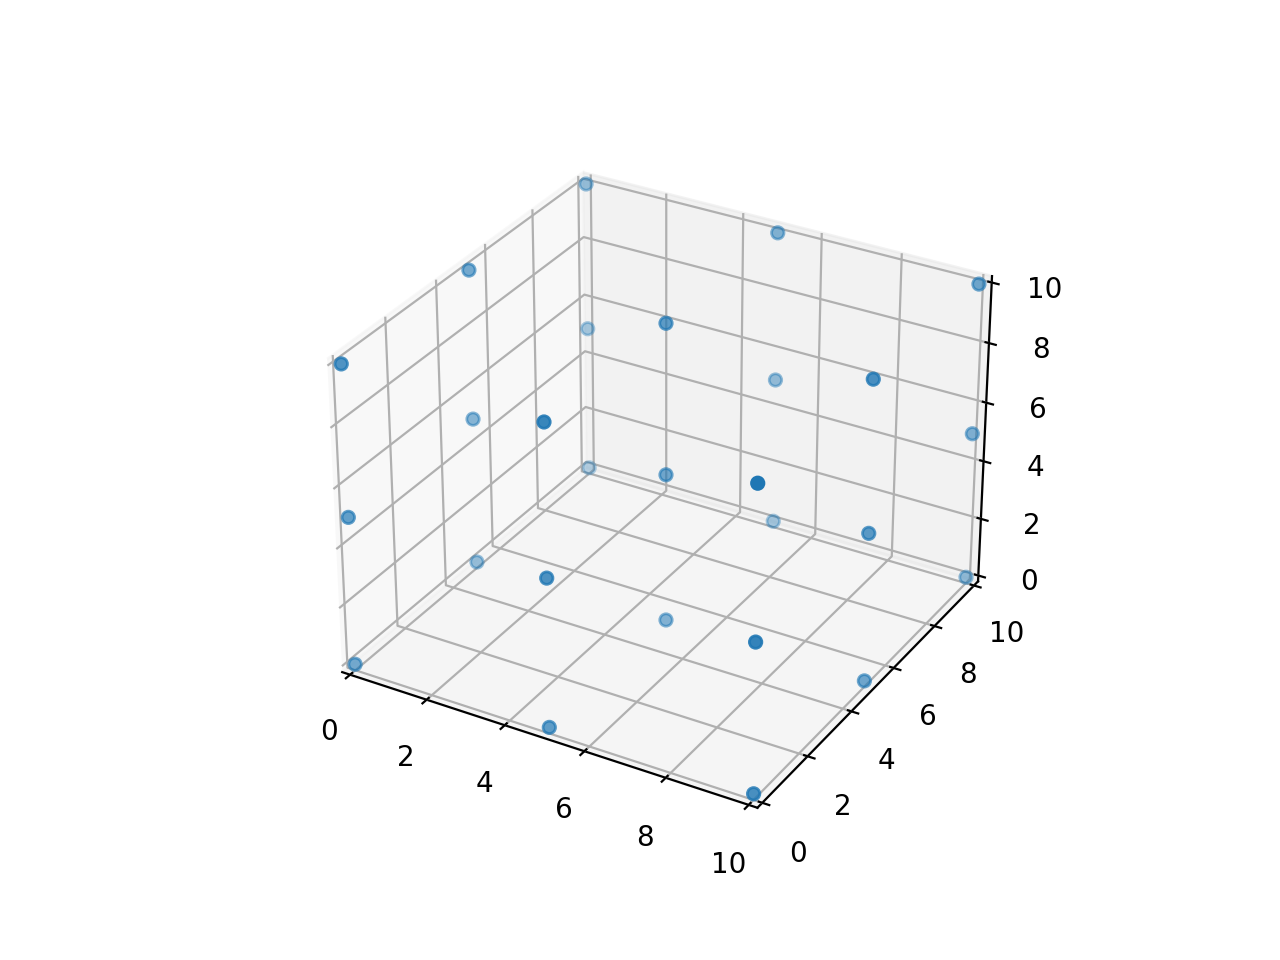

In [209]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation


#Creation of my particle
plot_particles = particle_array(n=3, dims=[0, 10, 0, 50])
duration = 100


##############################################################
#The creation of my figure                                   #
fig = plt.figure()                                           #
ax = fig.add_subplot(111, projection='3d')                   #
#Creating a global variable scat to store particle positions #
scat = ax.scatter([], [], [])                                #
##############################################################

def init():
    """
    Creates my starting particle positions on the graph
    """
    ax.clear()
    ax.set_xlim3d([0, 10])
    ax.set_ylim3d([0, 10])
    ax.set_zlim3d([0, 10])
    scat = ax.scatter(
        [particle.p[0] for particle in plot_particles.particles],
        [particle.p[1] for particle in plot_particles.particles],
        [particle.p[2] for particle in plot_particles.particles]
    )
    return scat

def animate(frame):
    """
    This is the function that FuncAnimation will call at each time point.
    Basically What I will have to do here is to do what particles.whee() does for me.
    """
    plot_particles.move()    
    plot_particles.calc_density()
    plot_particles.calc_pressure()
    plot_particles.calc_accel()
    plot_particles.calc_veloc()
        
    scat._offsets3d = (
        [particle.p[0] for particle in plot_particles.particles],
        [particle.p[1] for particle in plot_particles.particles],
        [particle.p[2] for particle in plot_particles.particles]
    )
    return scat,



ani = FuncAnimation(fig, animate, frames=duration, init_func=init, blit=True, interval=5)
plt.show()